# Proyecto 3. Predicción de valor Etherum. Héctor Ayuso Martín.

## Para ello , haremos uso de GRU/LSIMS, analizando tendencias y precios y construyendo modelos de ML, y realizando una IU en Flusk

### El objetivo final será la predicción de valor del precio en el cierre , basandonos en valores de precio anteriores.

### DataFrame from Kagle. El DF tiene un readme.txt donde se explica cada columna del mismo detalladamente.

#
#


In [1]:
'''

1:

Procesamiento de datos.


'''



'\n\n1:\n\nProcesamiento de datos.\n\n\n'

In [102]:
#importando librerias necesarias:

import pandas as pd
import numpy as np
import seaborn as sns
import math
import matplotlib.pyplot as plt

In [103]:
#leyendo el DF
data = pd.read_csv('ETH_1H.csv' , parse_dates=['Date'], index_col=['Date'])

In [104]:
#comprobamos la carga correcta del DF mostrando las 5 primeras filas:
data.head()

,Unix Timestamp,Symbol,Open,High,Low,Close,Volume
Date,,,,,,,
2020-04-16 00:00:00,1586995200000,ETHUSD,152.94,152.94,150.39,150.39,650.188125
2020-04-15 23:00:00,1586991600000,ETHUSD,155.81,155.81,151.39,152.94,4277.567299
2020-04-15 22:00:00,1586988000000,ETHUSD,157.18,157.30,155.32,155.81,106.337279
2020-04-15 21:00:00,1586984400000,ETHUSD,158.04,158.31,157.16,157.18,55.244131
2020-04-15 20:00:00,1586980800000,ETHUSD,157.10,158.10,156.87,158.04,144.262622


In [105]:
#Observando mas detalles del DF
data.shape
# 34497 filas x 7 columnas

(34497, 7)

In [106]:
#con el .head anterior se puede afirmar que data sort esta en orden descendente, vamos a cambiarlo a ascendente:
data = data.sort_index()

In [107]:
data.head()
#Comprobamos que los datos han sido modificados con la funcion sort_index()

,Unix Timestamp,Symbol,Open,High,Low,Close,Volume
Date,,,,,,,
2016-05-09 13:00:00,1462798800,ETHUSD,0.00,12.00,0.00,9.55,432.562115
2016-05-09 14:00:00,1462802400,ETHUSD,9.55,10.00,9.55,10.00,235.774075
2016-05-09 15:00:00,1462806000,ETHUSD,10.00,10.00,9.99,9.99,10.973567
2016-05-09 16:00:00,1462809600,ETHUSD,9.99,9.99,9.79,9.83,62.379450
2016-05-09 17:00:00,1462813200,ETHUSD,9.83,9.83,9.48,9.49,329.553213


In [171]:
data.tail()
#el dataset va del 9 de mayo de 2016 hasta el 15 de Abril de 2020.

,Open,High,Low,Close,Volume
Date,,,,,
2020-04-15 20:00:00,157.10,158.10,156.87,158.04,144.262622
2020-04-15 21:00:00,158.04,158.31,157.16,157.18,55.244131
2020-04-15 22:00:00,157.18,157.30,155.32,155.81,106.337279
2020-04-15 23:00:00,155.81,155.81,151.39,152.94,4277.567299
2020-04-16 00:00:00,152.94,152.94,150.39,150.39,650.188125


In [108]:
#Continumos obervando en el DF si hay NaN y su suma:
data.isna().sum()

Unix Timestamp    0
Symbol            0
Open              0
High              0
Low               0
Close             0
Volume            0
dtype: int64

In [109]:
#El DF esta limpio de NaN. Miremos duplicados y sumemoslos.
data.duplicated().sum()
#sin datos duplicados

0

In [110]:
#Ya que el simbolo y el Timestamp tienen valores unicos y no son utiles para las predicciones, las eliminamos:
data = data.drop(columns=['Unix Timestamp','Symbol'])


In [111]:
data.shape

(34497, 5)

In [112]:
data.columns

Index(['Open', 'High', 'Low', 'Close', 'Volume'], dtype='object')

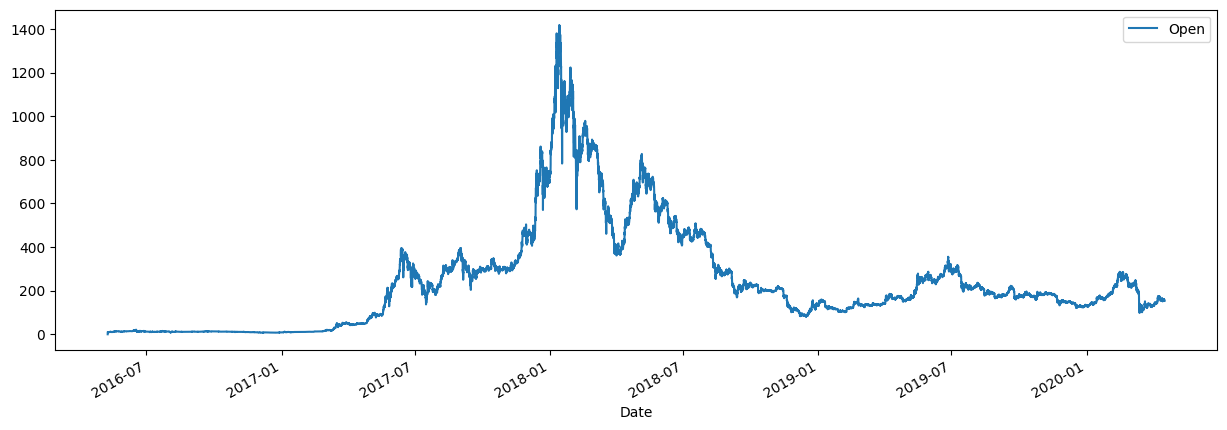

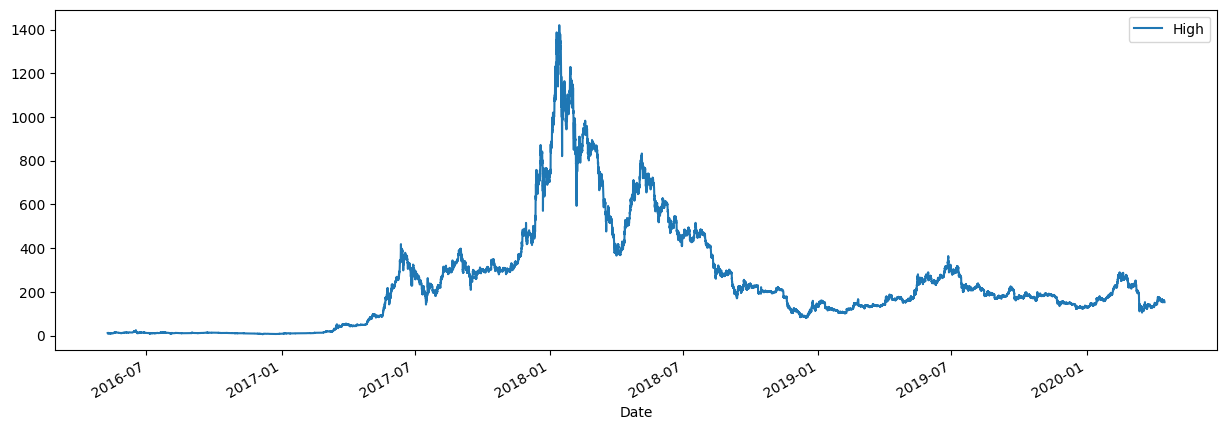

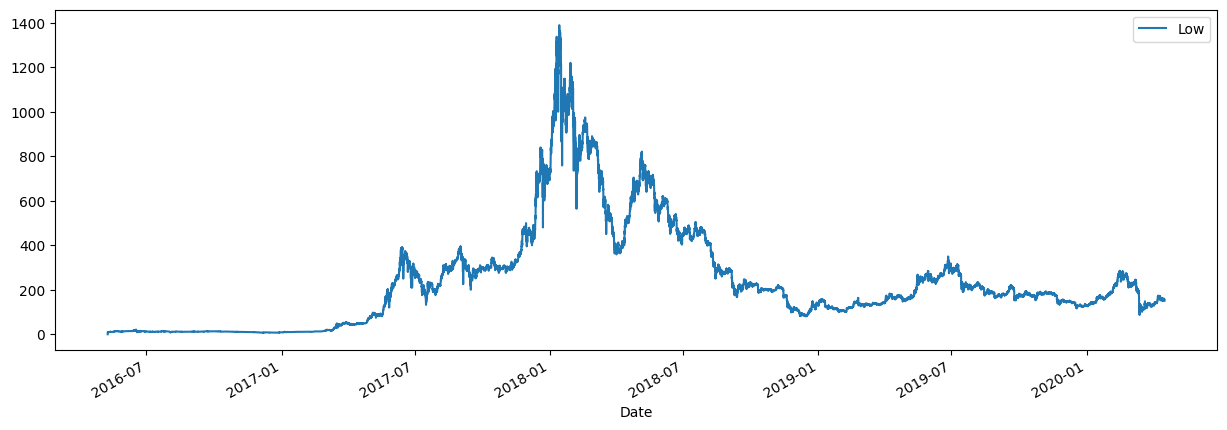

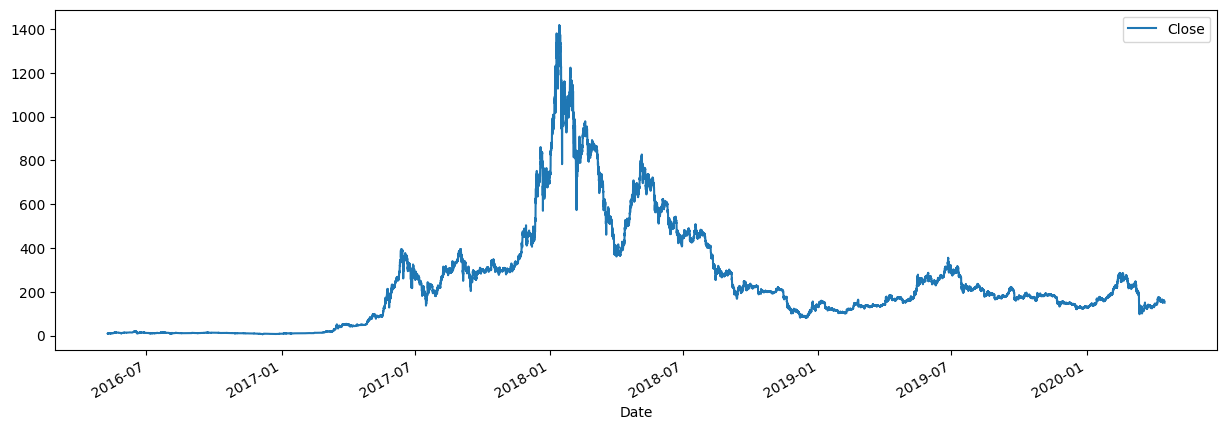

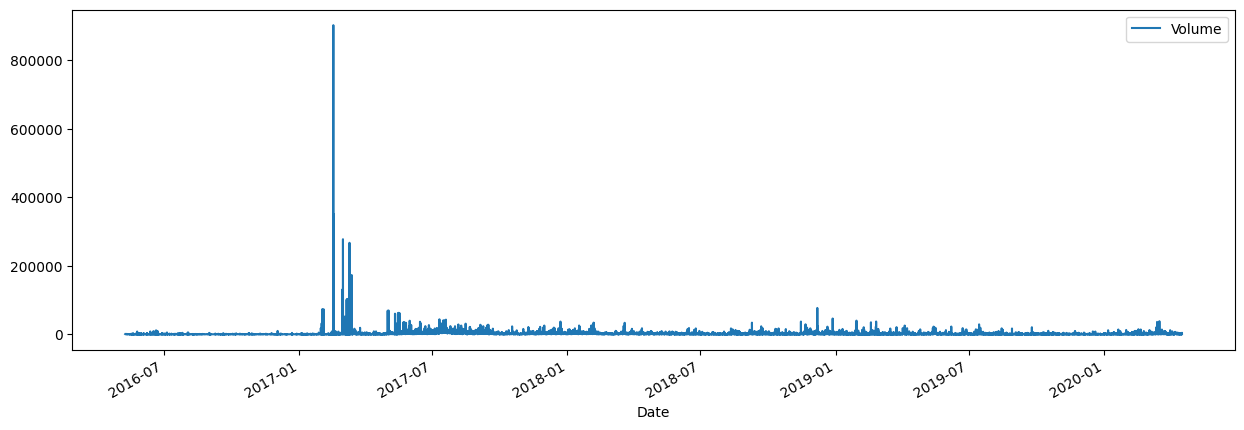

In [113]:
#Pasamos a graficar cada columna : (hacemos uso de un bucle for para iterar cada columna de el DF)
for i in data:
    plt.figure(figsize=(15,5))
    data[i].plot(legend=i)
    plt.show()


In [114]:
# A continuación , vamos a crear caracteristicas de DateTime extrayendo la hora, dia..etc: Creamos una funcion para ello.

def create_features(df):
    
    df = df.copy()
    df['hour'] = df.index.hour
    df['day'] = df.index.day
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofweek'] = df.index.dayofweek
    df['dayofyear'] = df.index.dayofyear
    df['weekofyear'] = df.index.isocalendar().week
    
    return df
    


In [115]:
#Ahora usando la funcion anteriormente creada, pasamos los datos

df = create_features(data)

In [116]:
df.head()
#observamos en el nuevo df , que tenemos el anterior data + las nuevas features de la funcion create_f.


,Open,High,Low,Close,Volume,hour,day,month,year,dayofweek,dayofyear,weekofyear
Date,,,,,,,,,,,,
2016-05-09 13:00:00,0.00,12.00,0.00,9.55,432.562115,13,9,5,2016,0,130,19
2016-05-09 14:00:00,9.55,10.00,9.55,10.00,235.774075,14,9,5,2016,0,130,19
2016-05-09 15:00:00,10.00,10.00,9.99,9.99,10.973567,15,9,5,2016,0,130,19
2016-05-09 16:00:00,9.99,9.99,9.79,9.83,62.379450,16,9,5,2016,0,130,19
2016-05-09 17:00:00,9.83,9.83,9.48,9.49,329.553213,17,9,5,2016,0,130,19


<Axes: >

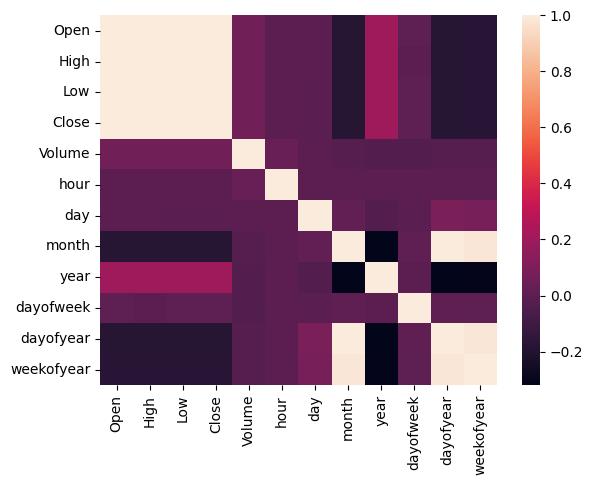

In [117]:
#Observemos la correlaccion entre estos valores con el objetico (y) [] usando un HM.
sns.heatmap(df.corr())


In [ ]:
'''

Generacion de datos de ventana deslizante para prediccion de valores fururos no vistos en DF

Logica Matematica:



Data = [1,2,3,4,5,6,7,8,9,10]

tamaño_de_ventana = 3 --> predice despues del entrenamiento con 3 inputs


[1,2,3]X -> [4]y
[2,3,4]X -> [5]y
[3,4,5]X -> [6]y  ...     




'''

In [118]:
#generando una ventana de 24h para predicir la siguiente hora, (hora'25') usando solo los valores de cierre:

close = df.iloc[:,3]
windows=[]
target=[]
length=240
for i in (range(len(close)-length)):
    x = close.iloc[i:i+length]
    y = close.iloc[i + length]
    windows.append(x)
    target.append(y)

windows = np.array(windows)
target = np.array(target).reshape(-1,1)


In [119]:
#Escalando las variables objetivo y caracteristicas para que sea mas facil para nuestro modelo aprender.

from sklearn.preprocessing import MinMaxScaler

sc = MinMaxScaler()
windows_sc = sc.fit_transform(windows)
target_sc = sc.fit_transform(target)

windows_sc = windows_sc.reshape((len(windows_sc),length,1))

In [120]:
#Hacemos el Split de los datos para pasar al modelo:

split = int(0.8*len(windows_sc))

X_train = windows_sc[:split,:,:]
X_test = windows_sc[split:,:,:]
y_train = target_sc[:split,:]
y_test = target_sc[split:,:]

In [121]:
#comprobamos tamaños del Split:
print(X_train.shape, y_train.shape)
#27405 muestras, cada uno con una longitud de 240. 240 caracteristicas de las cuales aprender, y la v objetico tiene un len de 27405 con un objetivo.

(27405, 240, 1) (27405, 1)


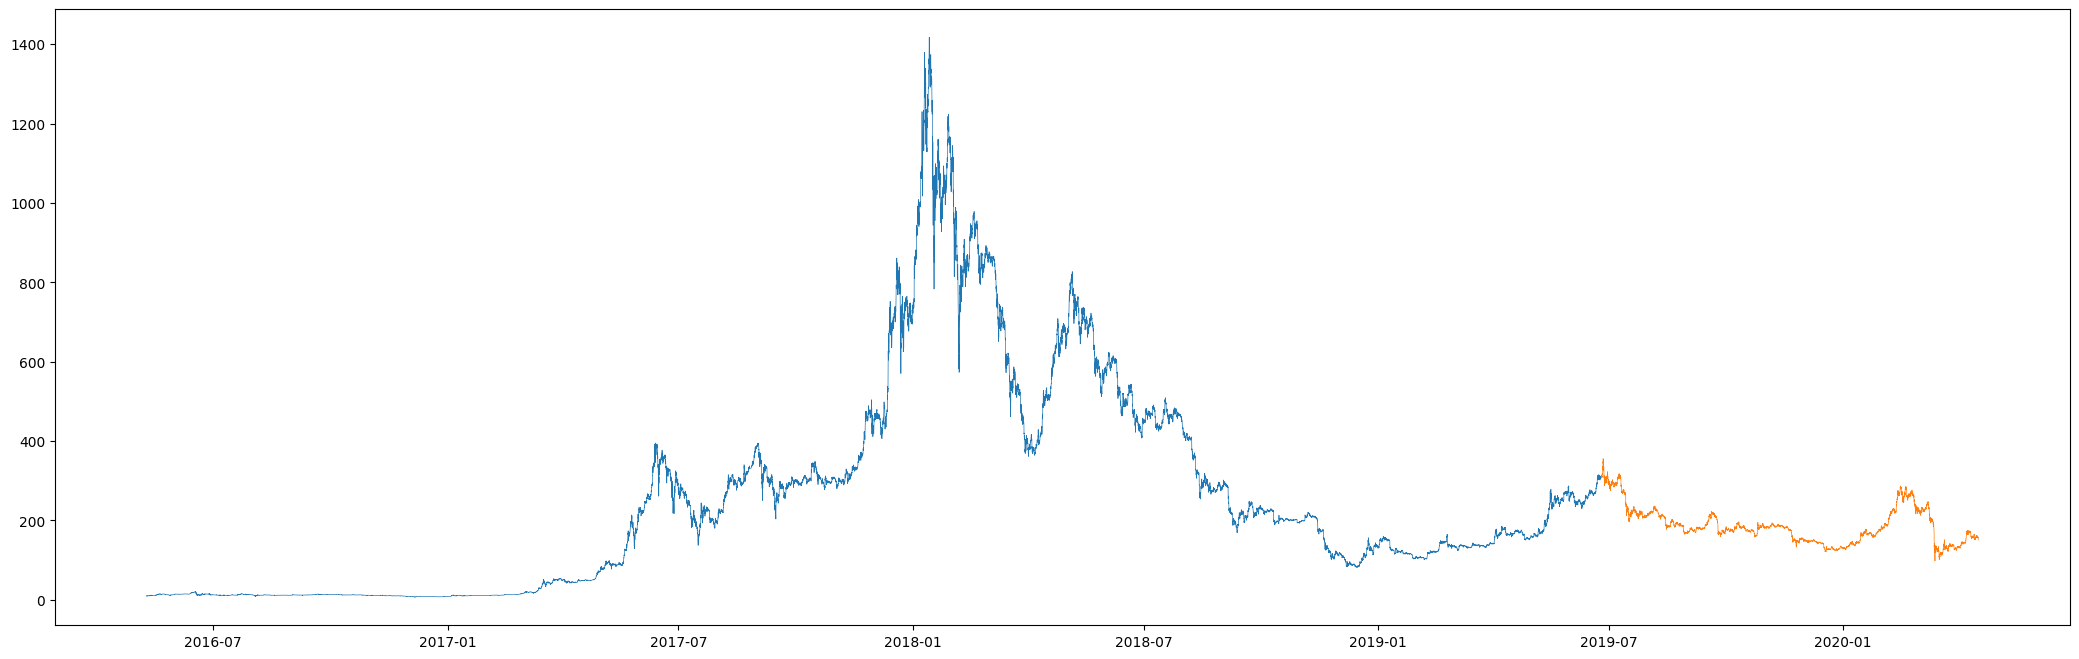

In [122]:
#graficando los datos train y test.
plt.figure(figsize=(26,8))
plt.plot(df['Close'][:split],label='Entrenamiento',linewidth=0.5)
plt.plot(df['Close'][split:],label='Datos de Prueba',linewidth=0.5)
#AZUL entrenamiento ( 80% ) naranja prueba

#
#


## Creación del Modelo y su entrenamiento

#
#


In [ ]:
#Redes Neuronales Recurrentes. LSTMs

In [52]:
#creacion del modelo



C:\Users\Héctor\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [128]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense, Input
from sklearn.metrics import *

model = Sequential([
    Input(shape=(X_train.shape[1], X_train.shape[2])),
    LSTM(100),
    Dropout(0.2),
    Dense(1, activation='linear')
])

model.compile(optimizer='adam', loss='mse')


In [129]:
#Sumario del modelo:
model.summary()
#40901 parametros entrenables.


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_6 (LSTM)                        │ (None, 100)                 │          40,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 1)                   │             101 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 40,901 (159.77 KB)

 Trainable params: 40,901 (159.77 KB)

 Non-trainable params: 0 (0.00 B)

In [130]:
#Entrenando el modelo con 5 epoc
model.fit(X_train,y_train,epochs=5,batch_size=100,verbose=1)

Epoch 1/5
275/275 ━━━━━━━━━━━━━━━━━━━━ 30s 103ms/step - loss: 0.0035
Epoch 2/5
275/275 ━━━━━━━━━━━━━━━━━━━━ 29s 105ms/step - loss: 2.6827e-04
Epoch 3/5
275/275 ━━━━━━━━━━━━━━━━━━━━ 29s 106ms/step - loss: 2.3007e-04
Epoch 4/5
275/275 ━━━━━━━━━━━━━━━━━━━━ 29s 105ms/step - loss: 2.0431e-04
Epoch 5/5
275/275 ━━━━━━━━━━━━━━━━━━━━ 29s 104ms/step - loss: 1.7955e-04


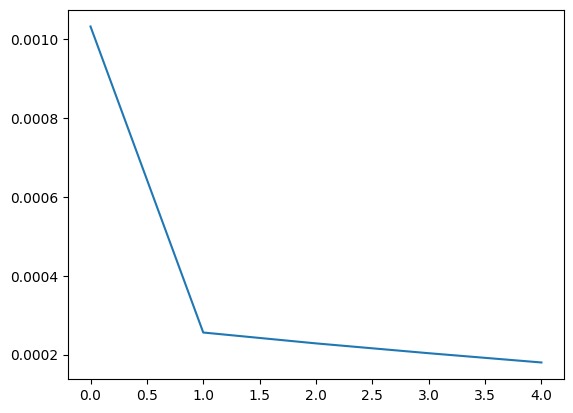

In [131]:
#graficamos la pérdida:
plt.plot(model.history.history['loss'])

In [132]:
#Haciendo las predicciones:
pred_sc = model.predict(X_test)
pred = sc.inverse_transform(pred_sc)
y_test_ic = sc.inverse_transform(y_test)

215/215 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step


In [133]:
#Observando metricas del modelo para apreciar que tiene una buena puntuacion.
#Coeficiente de determinacion (R ** 2)

print('El Coeficiente de determinacion ( R cuadrado )  = {:.3f}'.format(r2_score(pred,y_test_ic)))

El Coeficiente de determinacion ( R cuadrado )  = 0.994


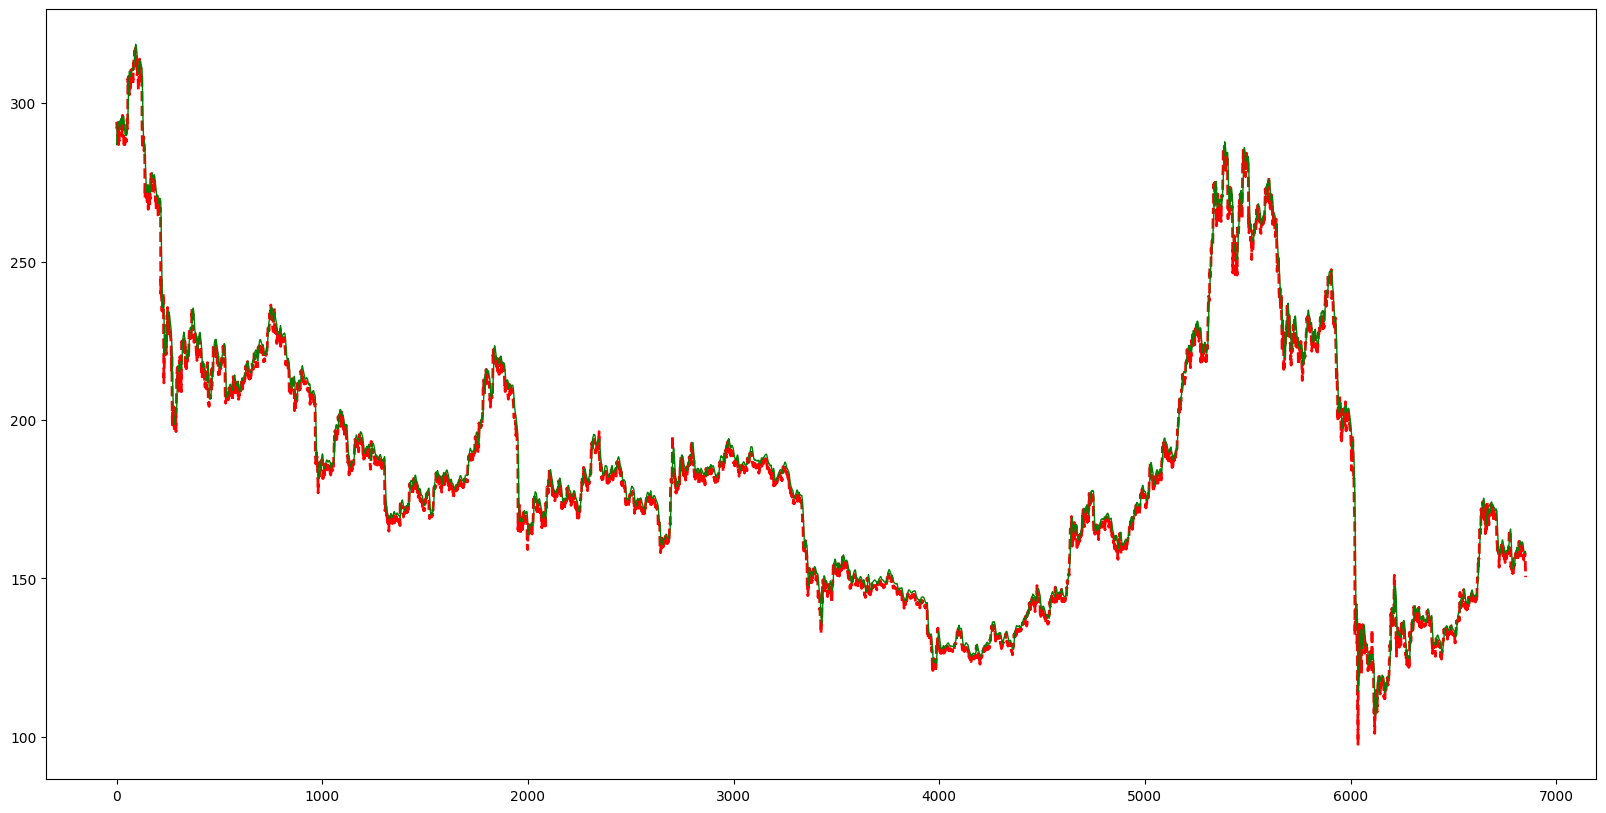

In [134]:
#graficandolo:
plt.figure(figsize=(20,10))
plt.plot(y_test_ic,'--',label='Actual',linewidth=2, color='Red')
plt.plot(pred,label='Prediccion',linewidth=1, color='Green')

#comparando la prediccion ( VERDE )con el valor objetivo real (ROJO)
#cOMPROBAMOS QUE LA PREDICCION ES MUY ACERTADA, con un R square de 0.995

### Predicciones a Futuro

In [135]:

model = Sequential([
    Input(shape=(X_train.shape[1], X_train.shape[2])),
    LSTM(100),  # 100 neuronas
    Dropout(0.2),  # Se eliminará el 20% de las neuronas
    Dense(1, activation='linear')  # Capa de salida
])

model.compile(optimizer='adam', loss='mse')


In [136]:
model.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_7 (LSTM)                        │ (None, 100)                 │          40,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 1)                   │             101 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 40,901 (159.77 KB)

 Trainable params: 40,901 (159.77 KB)

 Non-trainable params: 0 (0.00 B)

In [137]:
print('El Coeficiente de determinacion ( R cuadrado )  = {:.3f}'.format(r2_score(pred,y_test_ic)))

El Coeficiente de determinacion ( R cuadrado )  = 0.994


In [138]:
#Entrenamos-ajusta el modelo con el DataSet entero:

X = windows_sc
y = target_sc

model.fit(X , y , epochs = 5 , batch_size = 100 , verbose = 1)


Epoch 1/5
343/343 ━━━━━━━━━━━━━━━━━━━━ 38s 108ms/step - loss: 0.0033
Epoch 2/5
343/343 ━━━━━━━━━━━━━━━━━━━━ 36s 104ms/step - loss: 2.2243e-04
Epoch 3/5
343/343 ━━━━━━━━━━━━━━━━━━━━ 38s 111ms/step - loss: 1.7909e-04
Epoch 4/5
343/343 ━━━━━━━━━━━━━━━━━━━━ 36s 105ms/step - loss: 1.8828e-04
Epoch 5/5
343/343 ━━━━━━━━━━━━━━━━━━━━ 36s 104ms/step - loss: 1.6480e-04


In [188]:
from datetime import datetime
from tqdm import tqdm
str_d1 = '2020/04/16'#INICIO. Ultima fecha en el DF : el precio es de 140,53€
str_d2 = '2020/04/17'#Predecir hasta aqui: 30 de Abril del 2020. El precio deberia ser 195€ (precio sacado de historico)
                                                                                            #https://btcdirect.eu/es-es/precio-ethereum

#conviertiendo los String en Objetos DateTime

d1 = datetime.strptime(str_d1,"%Y/%m/%d") #INICIO. Ultima fecha en el DF
d2 = datetime.strptime(str_d2,"%Y/%m/%d") #Predecir hasta aqui: 30 de Abril del 2020

delta = d2-d1 #diferencia entre fechas

horas_pred_future = delta.days*24 #Diferencia en horas entre fechas

print('Horas de Futuro a predecir : ',horas_pred_future) #hay 336 horas en el tiempo Delta ( Delta =  Diferencia entre final y origen )

Horas de Futuro a predecir :  24


In [189]:
#Prediccion iterativa de cada paso(hora) futuro:

f_wind=windows_sc[-1]
f_tar=target_sc[-1]
new=[]

for i in tqdm(range(horas_pred_future)):
    curr = np.append(f_wind[1:],[f_tar]).reshape(-1,1)
    #print(curr,end="\n\n")
    next_pred = model.predict(curr.reshape(1,length,1))
    #pred_ic = sc.inverse_transform(next_pred)
    new.append(next_pred[0][0])
    f_wind = curr
    f_tar=next_pred

# Bucle recrusrivo que va a recorrer cada paso(hora) del futuro

  0%|                                                                                           | 0/24 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


  8%|██████▉                                                                            | 2/24 [00:00<00:01, 15.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 17%|█████████████▊                                                                     | 4/24 [00:00<00:01, 17.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 25%|████████████████████▊                                                              | 6/24 [00:00<00:00, 18.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 33%|███████████████████████████▋                                                       | 8/24 [00:00<00:00, 18.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 42%|██████████████████████████████████▏                                               | 10/24 [00:00<00:00, 18.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 50%|█████████████████████████████████████████                                         | 12/24 [00:00<00:00, 18.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 58%|███████████████████████████████████████████████▊                                  | 14/24 [00:00<00:00, 18.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 67%|██████████████████████████████████████████████████████▋                           | 16/24 [00:00<00:00, 18.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 75%|█████████████████████████████████████████████████████████████▌                    | 18/24 [00:00<00:00, 18.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 83%|████████████████████████████████████████████████████████████████████▎             | 20/24 [00:01<00:00, 18.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 92%|███████████████████████████████████████████████████████████████████████████▏      | 22/24 [00:01<00:00, 18.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [00:01<00:00, 18.35it/s]


In [190]:
#trasformacion de esacaldo inverso a los valores predichos

new = sc.inverse_transform(np.array(new).reshape(-1,1))

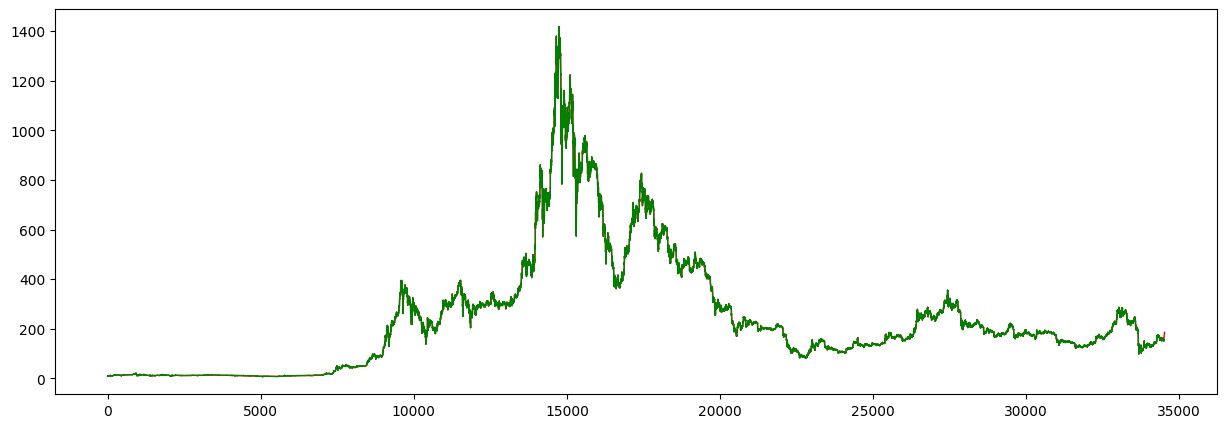

In [194]:
#graficando la prediccion

out = []
out = np.append(df.Close.values,new)
plt.figure(figsize=(15,5))
plt.plot(out,linewidth=1,color='red')
plt.plot(df.Close.values,linewidth=1,color='green')
plt.show()

#La prediccion dice que el dia siguiente al ultimo del DF (16/04/2020) , sube el valor

#comprobando con el historico:        https://btcdirect.eu/es-es/precio-ethereum   

#Ese dia el precio paso de 140 a 158. La predicción en este caso resulto afirmativa

## Guardando el modelo

In [93]:
import pickle


model.save('model.h5')
filename = 'scaler.pkl'
f = open(filename, 'wb')
pickle.dump(sc,f )
f.close()


In [94]:
with open('window.npy', 'wb') as f:
    np.save(f, windows_sc)
with open('target.npy', 'wb') as f:
    np.save(f, target_sc)